# Проект: Сервис поиска похожих вопросов для медицинских форумов

## Описание

### Цель

Целью данного проекта является разработка сервиса для поиска похожих вопросов на медицинских форумах. Сервис поможет удержать пользователей на платформе и увеличить количество просмотров страниц, что в свою очередь повысит эффективность рекламных кампаний и улучшит общие показатели форумов.

### Исходные данные

Для обучения и тестирования моделей используется датасет "medical_questions_pairs" от Hugging Face.  Датасет содержит пары вопросов на английском языке, связанных с медицинской тематикой.

### Методы

В проекте будут использованы следующие методы и технологии:

* Обработка естественного языка (NLP) для анализа и предобработки текстовых данных.
* Машинное обучение с использованием различных моделей NLP, таких как Bag-of-Words, TF-IDF, Word2Vec, SentenceTransformers и BERT. 
* FastAPI для создания микросервиса, предоставляющего функциональность поиска похожих вопросов.
* Streamlit для разработки интерактивного веб-приложения для демонстрации работы сервиса.

### Метрики оценки

Качество матчинга вопросов будет оцениваться с использованием следующих метрик: 

* Accuracy@5 - `ключевая метрика`
* Hits@K
* MRR@K (Mean Reciprocal Rank)
* DCG@K (Discounted Cumulative Gain)

## Импорты

In [2]:
import random
from datetime import datetime
from datasets import load_dataset
import pandas as pd
import numpy as np
import spacy
import nltk
import matplotlib.pyplot as plt
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.metrics import dcg_score
from skimpy import skim
import time
import chime
from tqdm import tqdm
chime.theme('mario')
%load_ext chime
from sentence_transformers import SentenceTransformer, util, losses, InputExample, LoggingHandler
from collections import defaultdict
from scipy.spatial.distance import pdist, squareform
from pickle import dump
from torch.utils.data import DataLoader

plt.style.use('dark_background')

## Загрузка и обзор данных

In [16]:
# Загрузка датасета medical_questions_pairs
try:
    train_df = pd.read_csv('train.csv')

except:
    
    dataset = load_dataset("medical_questions_pairs")

    # Преобразование датасета в pandas DataFrame
    train_df = pd.DataFrame(dataset['train'])
    train_df.to_csv('train.csv',index=False)

# Изучение структуры датасета
print('TRAIN')
print(train_df.info())
print('-------------------')
print()
print('TRAIN')
skim(train_df)
display(train_df.head(3))
print(f'Количество дубликатов: {train_df.duplicated().sum()}')
print(f'Количество уникальных question_1: {train_df.question_1.unique().shape[0]}')
print(f'Количество уникальных question_2: {train_df.question_2.unique().shape[0]}')
sum_len = len(set(list(train_df.question_1.unique())+list(train_df.question_2.unique())))
print(f'Суммарное количество уникальных вопросов: {sum_len}')

TRAIN
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3048 entries, 0 to 3047
Data columns (total 4 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   dr_id       3048 non-null   int64 
 1   question_1  3048 non-null   object
 2   question_2  3048 non-null   object
 3   label       3048 non-null   int64 
dtypes: int64(2), object(2)
memory usage: 95.4+ KB
None
-------------------

TRAIN


╭──────────────────────────────────────────────── skimpy summary ─────────────────────────────────────────────────╮
│          Data Summary                Data Types                                                                 │
│ ┏━━━━━━━━━━━━━━━━━━━┳━━━━━━━━┓ ┏━━━━━━━━━━━━━┳━━━━━━━┓                                                          │
│ ┃ dataframe         ┃ Values ┃ ┃ Column Type ┃ Count ┃                                                          │
│ ┡━━━━━━━━━━━━━━━━━━━╇━━━━━━━━┩ ┡━━━━━━━━━━━━━╇━━━━━━━┩                                                          │
│ │ Number of rows    │ 3048   │ │ int32       │ 2     │                                                          │
│ │ Number of columns │ 4      │ │ string      │ 2     │                                                          │
│ └───────────────────┴────────┘ └─────────────┴───────┘                                                          │
│                                                     number                                                      │
│ ┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━┳━━━━━━━━━━┳━━━━━━━━━━┳━━━━━━━━┳━━━━━━━┳━━━━━━━━┳━━━━━━━━┳━━━━━━━━━┳━━━━━━━━━━━┓  │
│ ┃ column_name         ┃ NA    ┃ NA %     ┃ mean     ┃ sd     ┃ p0    ┃ p25    ┃ p75    ┃ p100    ┃ hist      ┃  │
│ ┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━╇━━━━━━━━━━╇━━━━━━━━━━╇━━━━━━━━╇━━━━━━━╇━━━━━━━━╇━━━━━━━━╇━━━━━━━━━╇━━━━━━━━━━━┩  │
│ │ dr_id               │     0 │        0 │        6 │    3.1 │     1 │      3 │      9 │      11 │  ██▄███   │  │
│ │ label               │     0 │        0 │      0.5 │    0.5 │     0 │      0 │      1 │       1 │  █    █   │  │
│ └─────────────────────┴───────┴──────────┴──────────┴────────┴───────┴────────┴────────┴─────────┴───────────┘  │
│                                                     string                                                      │
│ ┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━┓  │
│ ┃ column_name               ┃ NA      ┃ NA %       ┃ words per row                ┃ total words              ┃  │
│ ┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━┩  │
│ │ question_1                │       0 │          0 │                           19 │                    57264 │  │
│ │ question_2                │       0 │          0 │                           19 │                    57264 │  │
│ └───────────────────────────┴─────────┴────────────┴──────────────────────────────┴──────────────────────────┘  │
╰────────────────────────────────────────────────────── End ──────────────────────────────────────────────────────╯

,dr_id,question_1,question_2,label
0,1,After how many hour from drinking an antibioti...,I have a party tonight and I took my last dose...,1
1,1,After how many hour from drinking an antibioti...,I vomited this morning and I am not sure if it...,0
2,1,Am I over weight (192.9) for my age (39)?,I am a 39 y/o male currently weighing about 19...,1


Количество дубликатов: 0
Количество уникальных question_1: 1524
Количество уникальных question_2: 3043
Суммарное количество уникальных вопросов: 4567


In [14]:
len(list(train_df.question_1.unique())+list(train_df.question_2.unique()))

4567

In [15]:
len(set(list(train_df.question_1.unique())+list(train_df.question_2.unique())))

4567

In [9]:
print(train_df.question_1.unique().shape[0])
print(train_df.question_2.unique().shape[0])
print()

1524

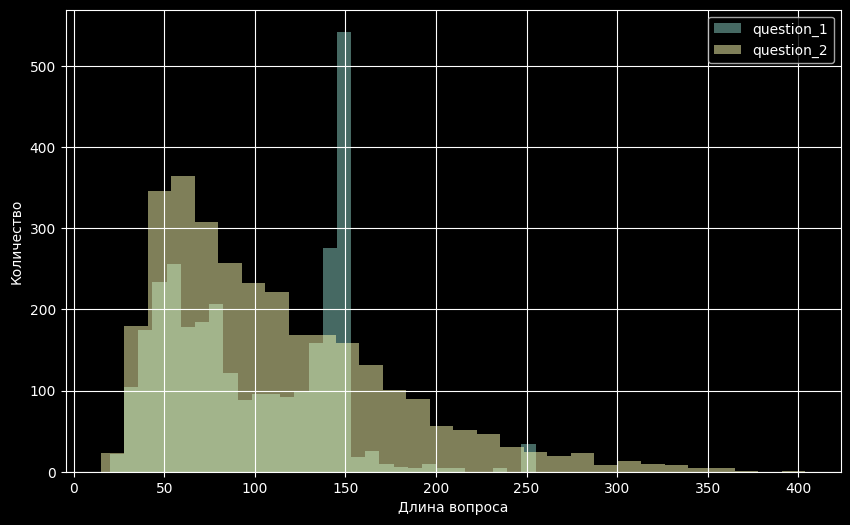

In [3]:
# Анализ длины вопросов
train_df['question_1_length'] = train_df['question_1'].str.len()
train_df['question_2_length'] = train_df['question_2'].str.len()

# Визуализация распределения длины вопросов
plt.figure(figsize=(10, 6))
train_df['question_1_length'].hist(bins=30, alpha=0.5, label='question_1')
train_df['question_2_length'].hist(bins=30, alpha=0.5, label='question_2')
plt.set_cmap('Greens')
plt.xlabel('Длина вопроса')
plt.ylabel('Количество')
plt.legend()
plt.show()

In [4]:
train_df['question_1_length'].describe()

count    3048.000000
mean       99.858924
std        45.640730
min        20.000000
25%        58.000000
50%        94.000000
75%       144.000000
max       255.000000
Name: question_1_length, dtype: float64

In [5]:
train_df['question_2_length'].describe()

count    3048.000000
mean      110.334646
std        63.029785
min        15.000000
25%        62.000000
50%        95.000000
75%       146.000000
max       404.000000
Name: question_2_length, dtype: float64

## Предобработка

In [6]:
nltk.download('punkt')
nltk.download('stopwords')

# Загрузка модели spaCy
nlp = spacy.load("en_core_web_trf")

def preprocess_text(text):
    """
    Функция для предобработки текста.

    Args:
        text (str): Входной текст.

    Returns:
        list: Список обработанных токенов.
    """
    # Токенизация
    tokens = nltk.word_tokenize(text.lower())  # Приведение к нижнему регистру

    # Удаление пунктуации
    tokens = [token for token in tokens if token.isalnum()]

    # Удаление стоп-слов
    stop_words = nltk.corpus.stopwords.words('english')
    tokens = [token for token in tokens if token not in stop_words]

    # Лемматизация
    tokens = [token.lemma_ for token in nlp(" ".join(tokens))]

    # Обработка неизвестных слов (замена на UNK)
    tokens = [token if token != '-PRON-' else 'UNK' for token in tokens]

    return " ".join(tokens)

[nltk_data] Downloading package punkt to C:\Users\elpiz/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\elpiz/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [7]:
def preprocess_dataframe(df):
    """
    Функция для предобработки DataFrame с вопросами.

    Args:
        df (pd.DataFrame): DataFrame с вопросами.

    Returns:
        pd.DataFrame: DataFrame с предобработанными вопросами.
    """
    df['processed_question_1'] = df['question_1'].apply(preprocess_text)
    df['processed_question_2'] = df['question_2'].apply(preprocess_text)
    return df

In [67]:
%%time
%%chime

try:
    train_df = pd.read_csv('prep_train.csv')
except:
    train_df = preprocess_dataframe(train_df)
    train_df.to_csv('prep_train.csv', index=False)

CPU times: total: 172 ms
Wall time: 321 ms


## Тестирование моделей

### TF-IDF (НЕУДАЧА)

In [56]:
def get_top_similar_questions(vectorizer, question, question_vectors, n=5):
    """
    Функция для поиска n наиболее похожих вопросов.

    Args:
        question (str): Входной вопрос.
        question_vectors (scipy.sparse.csr_matrix): Матрица векторов TF-IDF.
        n (int, optional): Количество возвращаемых похожих вопросов. Defaults to 5.

    Returns:
        list: Список n наиболее похожих вопросов. 
    """
    # Векторизация входного вопроса
    question_vector = vectorizer.transform([preprocess_text(question)])

    # Вычисление косинусного сходства
    similarity = cosine_similarity(question_vector, question_vectors)[0]

    # Получение индексов наиболее похожих вопросов
    top_indices = np.argsort(similarity)[-n:]

    # Возврат наиболее похожих вопросов
    return train_df.loc[top_indices, 'question_1'].tolist()

def accuracy_at_k(actual, predicted, k=5):
    """
    Вычисляет Accuracy@k.

    Args:
        actual (list): Список истинных меток.
        predicted (list): Список списков предсказанных меток.
        k (int, optional): Значение k. Defaults to 5.

    Returns:
        float: Accuracy@k.
    """
    score = 0.0
    for i in range(len(actual)):
        if actual[i] in predicted[i][:k]:  # Проверяем только первые k элементов
            score += 1.0
    return score / len(actual)

def hits_at_k(actual, predicted, k=5):
    """
    Вычисляет Hits@k.

    Args:
        actual (list): Список истинных меток.
        predicted (list): Список списков предсказанных меток.
        k (int, optional): Значение k. Defaults to 5.

    Returns:
        float: Hits@k.
    """
    score = 0.0
    for i in range(len(actual)):
        if actual[i] in predicted[i][:k]:
            score += 1.0
    return score / len(actual)

def reciprocal_rank(actual, predicted):
    """
    Вычисляет Reciprocal Rank.

    Args:
        actual (list): Список истинных меток.
        predicted (list): Список списков предсказанных меток.

    Returns:
        float: Reciprocal Rank.
    """
    for i, p in enumerate(predicted):
        if actual in p:
            return 1.0 / (i + 1.0)
    return 0.0

def dcg_at_k(actual, predicted, k=5):
    """
    Вычисляет Discounted Cumulative Gain (DCG@k).

    Args:
        actual (list): Список истинных меток.
        predicted (list): Список списков предсказанных меток.
        k (int, optional): Значение k. Defaults to 5.

    Returns:
        float: DCG@k.
    """
    score = 0.0
    for i, p in enumerate(predicted[:k]):
        if p in actual:
            score += 1.0 / np.log2(i + 2)
    return score

def evaluate(df, question_vectors, vectorizer):
    """
    Функция для оценки качества модели.

    Args:
        df (pd.DataFrame): DataFrame с вопросами.
        question_vectors (scipy.sparse.csr_matrix): Матрица векторов TF-IDF.
        vectorizer (TfidfVectorizer): Объект TfidfVectorizer.
    """
    actual = df['question_1'].tolist()
    # predicted = df['question_2'].apply(lambda x: get_top_similar_questions(vectorizer, x, question_vectors, n=5)).tolist()
    predicted = []
    for question in tqdm(df['question_2']):
        predicted.append(get_top_similar_questions(vectorizer, question, question_vectors, n=5))

    print("Accuracy@5:", accuracy_at_k(actual, predicted))
    print("Hits@5:", hits_at_k(actual, predicted))
    print("MRR:", np.mean([reciprocal_rank(a, p) for a, p in zip(actual, predicted)]))
    print("DCG@5:", np.mean([dcg_at_k(a, p) for a, p in zip(actual, predicted)]))

Изменёнка

In [74]:
def get_top_similar_questions_indices(question, question_vectors, vectorizer, n=5):
    """
    Функция для поиска индексов n наиболее похожих вопросов.

    Args:
        question (str): Входной вопрос.
        question_vectors (scipy.sparse.csr_matrix): Матрица векторов TF-IDF.
        vectorizer (TfidfVectorizer): Объект TfidfVectorizer.
        n (int, optional): Количество возвращаемых индексов. Defaults to 5.

    Returns:
        list: Список n индексов наиболее похожих вопросов.
    """

    # Векторизация входного вопроса
    question_vector = vectorizer.transform([preprocess_text(question)])

    # Вычисление косинусного сходства
    similarity = cosine_similarity(question_vector, question_vectors)[0]

    # Получение индексов наиболее похожих вопросов
    top_indices = np.argsort(similarity)[-n:]

    # Возврат индексов наиболее похожих вопросов
    return top_indices.tolist()

def accuracy_at_k(actual, predicted, k=5):
    score = 0.0
    for i in range(len(actual)):
        if i in predicted[i][:k]:  # Проверяем наличие индекса в предсказанных
            score += 1.0
    return score / len(actual)

def hits_at_k(actual, predicted, k=5):
    score = 0.0
    for i in range(len(actual)):
        if i in predicted[i][:k]:
            score += 1.0
    return score / len(actual)

def reciprocal_rank(actual, predicted):
    for i, p in enumerate(predicted):
        if actual in p:
            return 1.0 / (i + 1.0)
    return 0.0

def dcg_at_k(actual, predicted, k=5):
    score = 0.0
    for i, p in enumerate(predicted[:k]):
        if actual in p:
            score += 1.0 / np.log2(i + 2)
    return score

def evaluate(df, question_vectors, vectorizer):
    """
    Функция для оценки качества модели.

    Args:
        df (pd.DataFrame): DataFrame с вопросами.
        question_vectors (scipy.sparse.csr_matrix): Матрица векторов TF-IDF.
        vectorizer (TfidfVectorizer): Объект TfidfVectorizer.
    """
    # actual_labels = df['label'].tolist()
    # predicted = df['question_2'].apply(lambda x: get_top_similar_questions(vectorizer, x, question_vectors, n=5)).tolist()
    actual_labels = [[i] if label == 1 else [] for i, label in enumerate(train_df['label'])]
    predicted = []
    for question in tqdm(df['question_2']):
        predicted.append(get_top_similar_questions_indices(question, question_vectors, vectorizer, n=5))

    print("Примеры predicted:")
    print(predicted[:5])
    print("Примеры actual:")
    print(actual_labels[:5])
    print('------------------------')
    print("Accuracy@5:", accuracy_at_k(actual_labels, predicted))
    print("Hits@5:", hits_at_k(actual_labels, predicted))
    print("MRR:", np.mean([reciprocal_rank(a, p) for a, p in zip(actual_labels, predicted)]))
    print("DCG@5:", np.mean([dcg_at_k(a, p) for a, p in zip(actual_labels, predicted)]))

In [93]:
def get_top_similar_questions_indices(question, question_vectors, vectorizer, n=5):
    """
    Функция для поиска индексов n наиболее похожих вопросов.

    Args:
        question (str): Входной вопрос.
        question_vectors (scipy.sparse.csr_matrix): Матрица векторов TF-IDF.
        vectorizer (TfidfVectorizer): Объект TfidfVectorizer.
        n (int, optional): Количество возвращаемых индексов. Defaults to 5.

    Returns:
        list: Список n индексов наиболее похожих вопросов.
    """

    # Векторизация входного вопроса
    question_vector = vectorizer.transform([preprocess_text(question)])

    # Вычисление косинусного сходства
    similarity = cosine_similarity(question_vector, question_vectors)[0]

    # Получение индексов наиболее похожих вопросов
    top_indices = np.argsort(similarity)[-n:]

    # Возврат индексов наиболее похожих вопросов
    return top_indices.tolist()

def accuracy_at_k(actual, predicted, k=5):
    """
    Вычисляет Accuracy@k.

    Args:
        actual (list): Список списков с индексами релевантных вопросов.
        predicted (list): Список списков с индексами k наиболее похожих вопросов.
        k (int, optional): Значение k. Defaults to 5.

    Returns:
        float: Accuracy@k.
    """
    score = 0.0
    for i in range(len(actual)):
        if any(a in predicted[i][:k] for a in actual[i]):
            score += 1.0
    return score / len(actual)


def hits_at_k(actual, predicted, k=5):
    """
    Вычисляет Hits@k.

    Args:
        actual (list): Список списков с индексами релевантных вопросов.
        predicted (list): Список списков с индексами k наиболее похожих вопросов.
        k (int, optional): Значение k. Defaults to 5.

    Returns:
        float: Hits@k.
    """
    score = 0.0
    for i in range(len(actual)):
        if set(actual[i]).intersection(predicted[i][:k]):
            score += 1.0
    return score / len(actual)


def reciprocal_rank(actual, predicted):
    """
    Вычисляет Reciprocal Rank.

    Args:
        actual (list): Список с индексом релевантного вопроса.
        predicted (list): Список с индексами похожих вопросов.

    Returns:
        float: Reciprocal Rank.
    """
    if actual:  # Проверяем, не пустой ли список actual
        for i, p in enumerate(predicted):
            if actual[0] == p:
                return 1.0 / (i + 1.0)
    return 0.0

def dcg_at_k(actual, predicted, k=5):
    """
    Вычисляет Discounted Cumulative Gain (DCG@k).

    Args:
        actual (list): Список с индексом релевантного вопроса.
        predicted (list): Список с индексами похожих вопросов.
        k (int, optional): Значение k. Defaults to 5.

    Returns:
        float: DCG@k.
    """
    score = 0.0
    if actual:
        for i, p in enumerate(predicted[:k]):
            if p == actual[0]:
                score += 1.0 / np.log2(i + 2)
    return score


def evaluate(df, question_vectors, vectorizer):
    """
    Функция для оценки качества модели.

    Args:
        df (pd.DataFrame): DataFrame с вопросами и метками.
        question_vectors (scipy.sparse.csr_matrix): Матрица векторов TF-IDF.
        vectorizer (TfidfVectorizer): Объект TfidfVectorizer.
    """
    actual_labels = [[i] if label == 1 else [] for i, label in enumerate(df['label'])]
    predicted = []
    for question in tqdm(df['question_2']):
        predicted.append(get_top_similar_questions_indices(question, question_vectors, vectorizer, n=5))

    print("Примеры predicted:")
    print(predicted[:20])
    print("Примеры actual:")
    print(actual_labels[:20])
    print('------------------------')

    print("Accuracy@5:", accuracy_at_k(actual_labels, predicted))
    print("Hits@5:", hits_at_k(actual_labels, predicted))
    print("MRR:", np.mean([reciprocal_rank(a, p) for a, p in zip(actual_labels, predicted)]))
    print("DCG@5:", np.mean([dcg_at_k(a, p) for a, p in zip(actual_labels, predicted)]))

In [83]:
# Создание объекта TfidfVectorizer с заданными параметрами
vectorizer = TfidfVectorizer(max_features=5000, ngram_range=(1,2), min_df=5, max_df=0.8)

# Обучение модели на предобработанных вопросах из question_1
vectorizer.fit(train_df['processed_question_1'])

# Преобразование вопросов из question_2 в векторы TF-IDF
question2_vectors = vectorizer.transform(train_df['processed_question_2'])

In [84]:
question = "How can I prevent glaucoma?"
similar_questions = get_top_similar_questions_indices(question, question2_vectors, vectorizer)
similar_questions

[2180, 1580, 366, 2017, 1536]

In [85]:
# Вычисление матрицы косинусного сходства
similarity_matrix = cosine_similarity(question2_vectors, vectorizer.transform(train_df['processed_question_1']))

#### Оценка качества и производительности без разбиения на train и test

In [86]:
# Оценка модели
evaluate(train_df, question2_vectors, vectorizer)

  1%|          | 24/3048 [00:02<05:19,  9.45it/s]


KeyboardInterrupt: 

In [94]:
# Оценка модели
evaluate(train_df[:200], question2_vectors[:200], vectorizer)

100%|██████████| 200/200 [00:20<00:00,  9.59it/s]

Примеры predicted:
[[97, 1, 74, 11, 0], [23, 43, 58, 14, 1], [144, 99, 27, 41, 2], [196, 156, 17, 106, 3], [43, 23, 10, 14, 4], [37, 170, 4, 22, 5], [161, 194, 132, 59, 6], [31, 86, 121, 12, 7], [88, 9, 100, 40, 8], [8, 59, 15, 17, 9], [43, 23, 4, 14, 10], [97, 10, 0, 74, 11], [167, 101, 7, 90, 12], [19, 196, 122, 16, 13], [58, 10, 23, 43, 14], [27, 20, 9, 17, 15], [105, 102, 76, 13, 16], [9, 59, 106, 15, 17], [78, 19, 162, 163, 18], [85, 103, 18, 121, 19]]
Примеры actual:
[[0], [], [2], [], [], [5], [], [7], [8], [], [10], [], [], [13], [], [15], [16], [], [], [19]]
------------------------
Accuracy@5: 0.495
Hits@5: 0.495
MRR: 0.09899999999999999
DCG@5: 0.19149213958109812


In [55]:
# Оценка модели
evaluate(train_df[:1000], question2_vectors[:1000], vectorizer)

100%|██████████| 1000/1000 [02:02<00:00,  8.19it/s]

Accuracy@5: 0.993
Hits@5: 0.993
MRR: 0.2638000000000001
DCG@5: 0.5962170180406452


### SentenceTransformers

In [267]:
def create_index(df, model, text_cols = ['processed_question_1','processed_question_2'], dump_pkl=False):
    """
    Создает индекс-эмбеддингов и словари для поиска похожих вопросов.

    Args:
        df (pd.DataFrame): DataFrame с текстовыми вопросами.
        model (str): Модель SentenceTransformer.
        text_cols (list): Названия текстовых столбцов - 2 текстовых элемента в списке. 
                        По умолчанию - ['processed_question_1','processed_question_2'].
        dump (bool): Если True, то сохраняет словари в файлы 'pkl'. По умолчанию - False.
        
    Returns:
        tuple: (словарь индекс-эмбеддингов, словарь индекс-вопрос, словарь вопрос-индекс, словарь с ground truth)
    """
    corpus = list(set(df[text_cols[0]].tolist() + df[text_cols[1]].tolist()))
    sen2idx = {text: i for i, text in enumerate(corpus)}
    idx2sen = {v: k for k, v in sen2idx.items()}
    idx2emd = {i: model.encode(str(text)) for i, text in idx2sen.items()}

    if dump_pkl:
        with open("idx2emb.pkl", "wb") as fid:
            dump(idx2emd, fid)
        with open("idx2sen.pkl", "wb") as fid:
            dump(idx2sen, fid)
        with open("sen2idx.pkl", "wb") as fid:
            dump(sen2idx, fid)

    gt = defaultdict(list)
    for _, row in df.iterrows():
        idx1 = sen2idx[row[text_cols[0]]]
        idx2 = sen2idx[row[text_cols[1]]]

        if row.label:
            gt[idx1].append(idx2)
            gt[idx2].append(idx1)

    return idx2emd, idx2sen, sen2idx, gt


In [240]:
def evaluate_model(idx2emd, gt, n=5, return_top_n_idx = False):
    """
    Оценивает модель SentenceTransformer на предоставленных данных.

    Args:
        idx2emd (dict): Словарь с индекс-эмбеддингами.
        gt (dict): Словарь с ground truth.
        n (int): Число, обозначающее N. По умолчанию - 5.

    Returns:
        tuple: (accuracy@n, mrr@k, dcg@k)
    """

    emb_list = []
    for i in range(len(idx2emd)):
        emb_list.append(idx2emd[i])
    arr = np.array(emb_list)
    dist = pdist(arr, metric="cosine")
    dist_matrix = squareform(dist)
    top_n_idx = np.argsort(dist_matrix)[:, :n+1]

    acc = []
    mrr_at_k = []
    dcg_at_k = []
    for j in range(top_n_idx.shape[0]):
        # Исключаем первый схожий вопрос
        rec_idx = top_n_idx[j, 1:]
        gt_idx = gt.get(j, [])
        if len(gt_idx) > 0:
            
            # Accuracy@N
            intersection = set(rec_idx).intersection(set(gt_idx))
            acc.append(len(intersection) > 0)

            # MRR@K
            ranking = [idx in gt_idx for idx in rec_idx]
            if any(ranking):
                mrr_at_k.append(1 / (ranking.index(True) + 1))
            else:
                mrr_at_k.append(0)

            # DCG@K 
            relevance = [1 if idx in gt_idx else 0 for idx in rec_idx]
            ideal_ranking = sorted(relevance, reverse=True)
            dcg_at_k.append(dcg_score([relevance], [ideal_ranking], k=n))

    if return_top_n_idx:
        return np.mean(acc), np.mean(mrr_at_k), np.mean(dcg_at_k), top_n_idx
    else:
        return np.mean(acc), np.mean(mrr_at_k), np.mean(dcg_at_k)


def evaluate_SentenceTransformer(model_name, df, text_cols=['processed_question_1', 'processed_question_2']):
    """
    Оценивает модель SentenceTransformer на предоставленных данных.

    Args:
        model_name (str): Название модели SentenceTransformer.
        df (pd.DataFrame): DataFrame с текстовыми вопросами.
        text_cols (list): Названия текстовых столбцов - 2 текстовых элемента в списке.
                        По умолчанию - ['processed_question_1', 'processed_question_2'].

    Returns:
        tuple: (accuracy@5, mrr@5, dcg@5)
    """

    model = SentenceTransformer(model_name)
    idx2emd, _, _, gt = create_index(df, model, text_cols)
    accuracy, mrr, dcg = evaluate_model(idx2emd, gt)
    return accuracy, mrr, dcg

In [281]:
def colorize_metrics_df(df):
    return (df.sort_values('DCG@5', ascending=0)
            .reset_index(drop=True)
            .style
            .set_caption("Метрики моделей SentenceTransformer")
            .format("{:.2%}",subset=metrics_cols)
            .format(precision=2,subset=['time'])
            .background_gradient(cmap='summer',subset=metrics_cols)
            .background_gradient(cmap='summer_r',subset=['time']))

In [270]:
%%time
%%chime

model_names = [ 'all-MiniLM-L6-v2',
                'paraphrase-MiniLM-L3-v2',
                'all-MiniLM-L12-v2',
                'multi-qa-MiniLM-L6-cos-v1',
                'paraphrase-multilingual-mpnet-base-v2',
                'all-distilroberta-v1',
                'multi-qa-distilbert-cos-v1',
                'multi-qa-mpnet-base-dot-v1',
                'all-mpnet-base-v2'
                ]
metrics_cols = ['Accuracy@5','MMR@5','DCG@5']

try:
    metrics = metrics.dropna()
    counter = metrics.shape[0]+1
except:
    try:
        metrics = pd.read_csv('metrics.csv').dropna()
        counter = metrics.shape[0]+1
    except:
        metrics = None
        counter = 0
    

for text_type in ['Изначальный', 'Предобработаный']:
    for model_name in model_names:

        if metrics is None:
            metrics = pd.DataFrame(columns=['model','text_type'])

        if (metrics.shape[0] == 0 or
            model_name+text_type not in (metrics.model + metrics.text_type).to_list()):

            metrics.loc[counter,'model'] = model_name
            metrics.loc[counter,'text_type'] = text_type
            
            if text_type == 'Изначальный':
                text_cols=['question_1', 'question_2']
            else:
                text_cols=['processed_question_1','processed_question_2']

            start = time.time()
            accuracy, mrr, dcg = evaluate_SentenceTransformer(model_name, train_df, text_cols)
            end = time.time()

            metrics.loc[counter,'Accuracy@5'] = round(accuracy, 4)
            metrics.loc[counter,'MMR@5'] = round(mrr, 4)
            metrics.loc[counter,'DCG@5'] = round(dcg, 4)
            metrics.loc[counter,'time'] = round(end-start, 4)

            counter +=1
            
            metrics_colored = colorize_metrics_df(metrics)

            display(metrics_colored, clear = True)

        else:
            pass
display(metrics, clear = True)

,model,text_type,Accuracy@5,MMR@5,DCG@5,time
0,paraphrase-MiniLM-L3-v2,Изначальный,0.9216,0.8224,0.8321,70.2567
1,all-MiniLM-L6-v2,Изначальный,0.9636,0.9039,0.9094,119.9742
2,all-MiniLM-L12-v2,Изначальный,0.9587,0.9013,0.9075,221.1694
3,multi-qa-MiniLM-L6-cos-v1,Изначальный,0.9583,0.8883,0.8949,119.9261
4,paraphrase-multilingual-mpnet-base-v2,Изначальный,0.9196,0.8495,0.8582,601.4907
5,all-distilroberta-v1,Изначальный,0.9478,0.8723,0.8805,301.6539
6,multi-qa-distilbert-cos-v1,Изначальный,0.9560,0.8995,0.9057,298.2505
7,multi-qa-mpnet-base-dot-v1,Изначальный,0.9524,0.8855,0.8937,647.0068
8,all-mpnet-base-v2,Изначальный,0.9682,0.9094,0.9167,655.8550
10,all-MiniLM-L6-v2,Предобработаный,0.9327,0.8341,0.8427,133.3721


CPU times: total: 1h 26min 22s
Wall time: 43min 17s


In [285]:
metrics_colored

,model,text_type,Accuracy@5,MMR@5,DCG@5,time
0,all-mpnet-base-v2,Изначальный,96.82%,90.94%,91.67%,655.86
1,all-MiniLM-L6-v2,Изначальный,96.36%,90.39%,90.94%,119.97
2,all-MiniLM-L12-v2,Изначальный,95.87%,90.13%,90.75%,221.17
3,multi-qa-distilbert-cos-v1,Изначальный,95.60%,89.95%,90.57%,298.25
4,multi-qa-MiniLM-L6-cos-v1,Изначальный,95.83%,88.83%,89.49%,119.93
5,multi-qa-mpnet-base-dot-v1,Изначальный,95.24%,88.55%,89.37%,647.01
6,all-distilroberta-v1,Изначальный,94.78%,87.23%,88.05%,301.65
7,paraphrase-multilingual-mpnet-base-v2,Изначальный,91.96%,84.95%,85.82%,601.49
8,multi-qa-distilbert-cos-v1,Предобработаный,92.91%,83.69%,84.59%,239.22
9,all-MiniLM-L6-v2,Предобработаный,93.27%,83.41%,84.27%,133.37


In [284]:
metrics.to_csv('metrics.csv', index = False)

**Наблюдения:**
* ***Модель all-mpnet-base-v2 показала наилучшую точность (Accuracy@5) как на исходных, так и на предобработанных данных.*** Это говорит о том, что эта модель хорошо подходит для нашей задачи поиска похожих вопросов.
* ***Предобработка текста не привела к улучшению точности.*** В большинстве случаях, точность даже немного снизилась. Это может быть связано с тем, что предобработка удаляет некоторую информацию, которая может быть полезна для модели.
* ***Модели среднего размера (all-MiniLM-L6-v2, all-MiniLM-L12-v2) также показали хорошую точность. Они могут быть хорошим выбором, если важна скорость работы.***
* *Модели, специально обученные для задач Question Answering (multi-qa-MiniLM-L6-cos-v1, multi-qa-distilbert-cos-v1, multi-qa-mpnet-base-dot-v1), показали немного худшую точность, чем all-mpnet-base-v2, all-MiniLM-L6-v2 и all-MiniLM-L12-v2.*
* Метрики `MMR@5`и`DCG@5` на уровене 90%+ (0.9+) указывают на то что в большинстве случаев модель ранжирует правильный вопрос на первое место и реже на второе и ниже.

**Выбор модели:**
- Для дальнейшей разработки я буду использовать модель **`all-MiniLM-L6-v2`**, которая показала почти такой же результат что и `all-mpnet-base-v2`, но при этом работает почти в 6 раз быстрее.

## Fine-tuning модели SentenceTransformers

In [287]:
def print_metrics(idx2emd, gt, n = 5):

    # Вызов функции и evaluate_model
    accuracy, mrr, dcg = evaluate_model(idx2emd, gt, n)

    # Печать результатов
    print(f"Accuracy@{n}: {accuracy:.4f}")
    print(f"MRR@{n}: {mrr:.4f}")
    print(f"DCG@{n}: {dcg:.4f}")

In [110]:
best = 'all-MiniLM-L6-v2'

In [81]:
# Создание списка InputExample
train_data = []
for index, row in train_df.iterrows():
    train_data.append(InputExample(texts=[row['question_1'], row['question_2']], label=float(row['label'])))

# Создание DataLoader
train_dataloader = DataLoader(train_data, shuffle=True, batch_size=16)

In [82]:
# Создание объекта SentenceTransformer
model = SentenceTransformer(best)

# Определение loss-функции
train_loss = losses.CosineSimilarityLoss(model)

logging_handler = LoggingHandler()

# Fine-tuning модели
tuned_model = model.fit(train_objectives=[(train_dataloader, train_loss)],
                        epochs=3)

Epoch:   0%|          | 0/1 [00:00<?, ?it/s]

Iteration:   0%|          | 0/191 [00:00<?, ?it/s]

In [93]:
%%time
%%chime

idx2emd, _, _, gt = create_index(train_df, tuned_model, text_cols = ['question_1','question_2'])
print_metrics(idx2emd, gt, 5)

Epoch:   0%|          | 0/10 [00:00<?, ?it/s]

Iteration:   0%|          | 0/191 [00:00<?, ?it/s]

Iteration:   0%|          | 0/191 [00:00<?, ?it/s]

Iteration:   0%|          | 0/191 [00:00<?, ?it/s]

Iteration:   0%|          | 0/191 [00:00<?, ?it/s]

Iteration:   0%|          | 0/191 [00:00<?, ?it/s]

Iteration:   0%|          | 0/191 [00:00<?, ?it/s]

Iteration:   0%|          | 0/191 [00:00<?, ?it/s]

Iteration:   0%|          | 0/191 [00:00<?, ?it/s]

Iteration:   0%|          | 0/191 [00:00<?, ?it/s]

Iteration:   0%|          | 0/191 [00:00<?, ?it/s]

CPU times: total: 2h 16min 57s
Wall time: 1h 18min 51s


In [102]:
def print_metrics(idx2emd, gt, n = 5):

    # Вызов функции и evaluate_model
    accuracy, mrr, dcg = evaluate_model(idx2emd, gt, n)

    # Печать результатов
    print(f"Accuracy@{n}:", accuracy)
    print(f"MRR@{n}:", mrr)
    print(f"DCG@{n}:", dcg)

In [100]:
idx2emd, _, _, gt = create_index(train_df, tuned_model, text_cols = ['question_1','question_2'])

In [288]:
print_metrics(idx2emd, gt, 5)

Accuracy@5: 0.9636
MRR@5: 0.9039
DCG@5: 0.9094


In [289]:
print_metrics(idx2emd, gt, 10)

Accuracy@10: 0.9793
MRR@10: 0.9061
DCG@10: 0.9057


* **Метрики ухудшились, попробую использовать другую loss-функцию - `TripletLoss`, которая будет лучше подходить для данного набора данных и задачи.**

In [117]:
from collections import defaultdict

def create_triplets(df):
    """
    Создает триплеты данных для TripletLoss.

    Args:
        df (pd.DataFrame): DataFrame с вопросами и метками.

    Returns:
        list: Список триплетов (anchor, positive, negative).
    """
    # Группировка вопросов по меткам
    groups = defaultdict(list)
    for index, row in df.iterrows():
        groups[row['label']].append(row['question_1'])

    # Создание триплетов
    triplets = []
    for label, group in groups.items():
        for anchor in group:
            for positive in group:
                if anchor != positive:
                    for negative_label, negative_group in groups.items():
                        if negative_label != label:
                            negative = random.choice(negative_group)
                            triplets.append(InputExample(texts=[anchor, positive, negative]))  # Создание InputExample
    return triplets

In [ ]:
from sentence_transformers import InputExample

def create_triplets(df):
    """
    Создает триплеты данных для TripletMarginLoss.

    Args:
        df (pd.DataFrame): DataFrame с вопросами и метками.

    Returns:
        list: Список объектов InputExample.
    """
    triplets = []
    for index, row in df.iterrows():
        if row['label'] == 1:
            # Положительный пример
            triplets.append(InputExample(texts=[row['question_1'], row['question_2'], df.loc[index-1, 'question_2']]))  # Берем предыдущий вопрос как отрицательный
        else:
            # Отрицательный пример (берем следующий вопрос как положительный)
            triplets.append(InputExample(texts=[row['question_1'], df.loc[index+1, 'question_2'], row['question_2']]))
    return triplets

In [150]:
import random

In [149]:
from collections import defaultdict
from sentence_transformers import InputExample

def create_triplets(df):
    """
    Создает триплеты данных для TripletMarginLoss.

    Args:
        df (pd.DataFrame): DataFrame с вопросами и метками.

    Returns:
        list: Список объектов InputExample.
    """
    # Группировка вопросов по меткам
    groups = defaultdict(list)
    for index, row in df.iterrows():
        groups[row['label']].append(row['question_1'])

    # Создание триплетов
    triplets = []
    for label, group in groups.items():
        for anchor in group:
            positive_group = groups[1] if label == 0 else groups[0]  # Выбираем группу с другой меткой
            positive = random.choice(positive_group)
            negative = random.choice(group)
            while negative == anchor:
                negative = random.choice(group)
            triplets.append(InputExample(texts=[anchor, positive, negative]))
    return triplets

In [201]:
from collections import defaultdict
from sentence_transformers import InputExample

def create_triplets(df, triplet_type = 'InputExample'):
    """
    Создает триплеты данных для TripletMarginLoss.

    Args:
        df (pd.DataFrame): DataFrame с вопросами и метками.

    Returns:
        list: Список объектов InputExample.
    """
    triplets = []

    for anchor in train_df.question_1.unique():
        for positive in train_df.query('label == 1').loc[train_df['question_1']==anchor,'question_2'].to_list():
            for negative in train_df.query('label == 0').loc[train_df['question_1']==anchor,'question_2'].to_list():
            
                if triplet_type == 'InputExample':
                    triplets.append(InputExample(texts=[anchor, positive, negative]))
                    
                elif triplet_type =='tuple':
                    triplets.append((anchor, positive, negative))
                
    return triplets

In [197]:
def evaluate_triplets(triplets, model):
    """
    Оценивает модель SentenceTransformer на триплетах данных.

    Args:
        triplets (list): Список триплетов (anchor, positive, negative).
        model (SentenceTransformer): Объект SentenceTransformer.

    Returns:
        float: Доля правильно классифицированных триплетов.
    """
    correct = 0
    for anchor, positive, negative in triplets:
        # Векторизация предложений
        anchor_embedding = model.encode(anchor)
        positive_embedding = model.encode(positive)
        negative_embedding = model.encode(negative)

        # Вычисление расстояний
        positive_distance = cosine_similarity(anchor_embedding.reshape(1, -1), positive_embedding.reshape(1, -1))[0][0]
        negative_distance = cosine_similarity(anchor_embedding.reshape(1, -1), negative_embedding.reshape(1, -1))[0][0]

        # Проверка условия
        if positive_distance > negative_distance:
            correct += 1

    return correct / len(triplets)

In [186]:
%%time
%%chime

model = SentenceTransformer(best)

# Создание триплетов данных
train_triplets = create_triplets(train_df)

# Создание DataLoader
train_dataloader = DataLoader(train_triplets, shuffle=True, batch_size=16)

# Создание объекта SentenceTransformer
model = SentenceTransformer(best)

# Определение loss-функции
train_loss = losses.TripletLoss(model=model)

# Добавление LoggingHandler
logging_handler = LoggingHandler()

# Fine-tuning модели
model.fit(train_objectives=[(train_dataloader, train_loss)], 
          epochs=10, 
          warmup_steps=100
          )

# Оценка качества модели
idx2emd, _, _, gt = create_index(train_df, model, text_cols = ['question_1','question_2'])

print_metrics(idx2emd, gt, 5)

Epoch:   0%|          | 0/10 [00:00<?, ?it/s]

Iteration:   0%|          | 0/96 [00:00<?, ?it/s]

Iteration:   0%|          | 0/96 [00:00<?, ?it/s]

Iteration:   0%|          | 0/96 [00:00<?, ?it/s]

Iteration:   0%|          | 0/96 [00:00<?, ?it/s]

Iteration:   0%|          | 0/96 [00:00<?, ?it/s]

Iteration:   0%|          | 0/96 [00:00<?, ?it/s]

Iteration:   0%|          | 0/96 [00:00<?, ?it/s]

Iteration:   0%|          | 0/96 [00:00<?, ?it/s]

Iteration:   0%|          | 0/96 [00:00<?, ?it/s]

Iteration:   0%|          | 0/96 [00:00<?, ?it/s]

Accuracy@5: 0.2335958005249344
MRR@5: 0.09706364829396326
DCG@5: 0.09103037353294799
CPU times: total: 1h 57min 5s
Wall time: 51min 34s


In [200]:
tuple_train_triplets

[]

In [202]:
tuple_train_triplets = create_triplets(train_df, triplet_type='tuple')

evaluate_triplets(tuple_train_triplets, model)

0.9429133858267716

In [204]:
base_model = SentenceTransformer(best)

tuple_train_triplets = create_triplets(train_df, triplet_type='tuple')

evaluate_triplets(tuple_train_triplets, base_model)

0.9481627296587927

**Базовая модель без дообучения показывает более высокую метрику `AccuracyTriplet` и значительно лучшие показатели целевых метрик `Accuracy@5, MRR@5, DCG@5`, чем модель дообученная с помощью `TripletLoss`**

In [211]:
gt

defaultdict(list,
            {4: [2],
             2: [4],
             5: [14],
             14: [5],
             12: [6],
             6: [12],
             10: [1],
             1: [10],
             11: [7],
             7: [11]})

In [222]:
gt[1][0]

10

In [224]:
idx2sen

{0: 'I vomited this morning and I am not sure if it is the side effect of my antibiotic or the alcohol I took last night...',
 1: 'Today morning, I had an appointment with the doctor. After that, I saw the nurse for a shot. As I got up, her box of tools fell all over me. She sent me home saying all is okay. But I am worried about an infection. Should I schedule another appointment for any blood tests?',
 2: 'I have a party tonight and I took my last dose of Azithromycin this morning. Can I have a few drinks?',
 3: 'Is it okay if I use the same syringe for my insulin shot? I need to take it thrice a day.',
 4: 'After how many hour from drinking an antibiotic can I drink alcohol?',
 5: 'Am I over weight (192.9) for my age (39)?',
 6: 'My friend told me about this bracelet for Aspirin allergy. Does it work the way they say it does?',
 7: "I am unable to get tooth extraction, my dentist is unable to give me anesthesia. Wouldn't antibiotics help with this since it has been going on for abou

In [226]:
top_n_idx

array([[ 0,  4,  2,  7,  9,  1],
       [ 1, 10, 11,  3,  7,  9],
       [ 2,  4,  0,  7,  8,  3],
       [ 3,  1, 12,  2, 10,  6],
       [ 4,  0,  2,  7,  8,  3],
       [ 5, 14, 13,  3, 12,  8],
       [ 6, 12,  8,  3, 11,  0],
       [ 7, 11,  9,  4,  1,  0],
       [ 8, 12,  6,  2,  4,  3],
       [ 9, 11,  7,  0,  1,  4],
       [10,  1, 11,  3,  0,  7],
       [11,  7,  9,  1, 10,  2],
       [12,  6,  8,  3,  2,  1],
       [13, 14,  5, 12,  6,  3],
       [14,  5, 13,  9, 12,  3]], dtype=int64)

In [225]:
train_df[:10]

,dr_id,question_1,question_2,label,question_1_length,question_2_length,processed_question_1,processed_question_2
0,1,After how many hour from drinking an antibioti...,I have a party tonight and I took my last dose...,1,68,101,many hour drinking antibiotic drink alcohol,party tonight take last dose azithromycin morn...
1,1,After how many hour from drinking an antibioti...,I vomited this morning and I am not sure if it...,0,68,118,many hour drinking antibiotic drink alcohol,vomit morning sure side effect antibiotic alco...
2,1,Am I over weight (192.9) for my age (39)?,I am a 39 y/o male currently weighing about 19...,1,41,82,weight age 39,39 male currently weigh 193 lb think overweight
3,1,Am I over weight (192.9) for my age (39)?,What diet is good for losing weight? Keto or v...,0,41,51,weight age 39,diet good lose weight keto vegan
4,1,Aspirin allergy - is it worth getting a bracelet?,How much Aspirin can I take for my headache wi...,0,49,77,aspirin allergy worth get bracelet,much aspirin take headache without cause side ...
5,1,Aspirin allergy - is it worth getting a bracelet?,My friend told me about this bracelet for Aspi...,1,49,97,aspirin allergy worth get bracelet,friend tell bracelet aspirin allergy work way say
6,1,"At a doctor's visit, I hit my head against a b...",Is it okay if I use the same syringe for my in...,0,146,89,doctor visit hit head box wall contain hazardo...,okay use syringe insulin shot need take thrice...
7,1,"At a doctor's visit, I hit my head against a b...","Today morning, I had an appointment with the d...",1,146,273,doctor visit hit head box wall contain hazardo...,today morning appointment doctor see nurse sho...
8,1,Been on antibiotics 4 5wks top high tooth dent...,"I am unable to get tooth extraction, my dentis...",1,148,183,antibiotics 4 5wk top high tooth dentist cld g...,unable get tooth extraction dentist unable giv...
9,1,Been on antibiotics 4 5wks top high tooth dent...,Why do I have black teeth? Should I take antib...,0,148,75,antibiotics 4 5wk top high tooth dentist cld g...,black tooth take antibiotic infection


In [242]:
top_n_idx[0,1:]

array([ 5, 14, 24, 23, 28], dtype=int64)

In [244]:
idx2emd, idx2sen, sen2idx, gt = create_index(train_df, base_model,
                                             text_cols=['question_1', 'question_2'],
                                             dump_pkl=True)

# Получение предсказаний (матрица top_n_idx)
_, _, _, top_n_idx = evaluate_model(idx2emd, gt, return_top_n_idx=True)  # Нам нужна только матрица top_n_idx

# Анализ предложенных вопросов
for i in range(len(top_n_idx[:5])):
    predicted_indices = top_n_idx[i,1:]
    true_indices = gt.get(i, [])
    if set(predicted_indices).intersection(set(true_indices)):
        print("Вопрос:")
        display(idx2sen[i])
        print("Предсказанные похожие вопросы:")
        display([idx2sen[j] for j in predicted_indices])
        print("Истинный похожий вопрос:")
        display([idx2sen[j] for j in true_indices])
        print("------------------------------------------") 

Вопрос:


'I think I have ED. Would this worsen as I grow old?'

Предсказанные похожие вопросы:


['I think I have ED. Can you help me?',
 'Does age increase the severity of eds symptoms/problems?',
 'I am 27 and have been on Cialis for ED for about 2 months now. But I notice that the symptoms are worsening and I cannot achieve and maintain an erection. Is it normal for this to happen while on medication?',
 'What other options do I have for ED apart from Cialis?',
 'I have ADHD since childhood and I have been on medications for it. Will it be forever? Will it affect my future and my career?']

Истинный похожий вопрос:


['Does age increase the severity of eds symptoms/problems?']

------------------------------------------
Вопрос:


'My thyroid tests results are 91 for thyroid peroxidase antibodies and <1 for thyroglobulin antibodies and TSH 4.44 and T3(liothyronine) and total is 72 and I have no symptoms. '

Предсказанные похожие вопросы:


['What does it mean to have 91 for THYROID PEROXIDASE ANTIBODIES, <1 for THYROGLOBULIN ANTIBODIES, TSH 4.44, and T3, (liothyronine) TOTAL 72; no symptoms?',
 "What would cause T3 (liothyronine) levels to be abnormal,  but tsh/t4 are normal? I'm not pregnant.",
 'Does a thyroid level in the TSH 4.1 to 5.2 range indicate hypothyroidism? Is very dry skin and increase in acne also a symptom?',
 'I have dry skin and acne, my TSH value in thyroid panel is between 4.1 to 5.2, I think I have hypothyroidism. What are my treatment options? ',
 'I have a very dry skin and increase in acne. Is it relate to hypothyroidism? My TSH value is between 4.1 to 5.2. ']

Истинный похожий вопрос:


['What does it mean to have 91 for THYROID PEROXIDASE ANTIBODIES, <1 for THYROGLOBULIN ANTIBODIES, TSH 4.44, and T3, (liothyronine) TOTAL 72; no symptoms?']

------------------------------------------
Вопрос:


'Can somebody give me advice I have knee pain(locking) for 5 months now?'

Предсказанные похожие вопросы:


['I have sustained injury to the knees. Is there anything I can do to help with the pain?',
 'What can cause knee pain for 5 months?',
 'I have been diagnosed with arthritis in the knees. What can I do to get some relief?',
 'I have a wrenched ligament in the knee, how long would it take to heal up? ',
 'I fell down 2 months back and my knee is swollen even now. Is this arthritis?']

Истинный похожий вопрос:


['What can cause knee pain for 5 months?']

------------------------------------------
Вопрос:


"I've had a lump by my bellyboutton and it moves around its been a week now could I have a hernia? I've been constapated too? Or pregnancy had neg test"

Предсказанные похожие вопросы:


['My symptoms are.....a movable bellybutton lump since a week, constipation. I was wondering if it is a hernia or can it be a pregnancy? Test was negative. ',
 "I'm a female age 29. Have pain by my belly button on and off. More recently have problem having a bum but only when pain is present. Possible hernia?",
 'How is a small lump in the groin from hernia treated?',
 "I'm currently 20 weeks pregnant and have been noticing lower abdominal pain and light bleeidng. Should I be worried? ",
 'I am a 29 year old female. The area around my belly button has been hurting on and off. But, recently, I have also noticed a swelling that shows up along with the pain. Do you think it could be a hernia?']

Истинный похожий вопрос:


['My symptoms are.....a movable bellybutton lump since a week, constipation. I was wondering if it is a hernia or can it be a pregnancy? Test was negative. ']

------------------------------------------


In [148]:
train_df

,dr_id,question_1,question_2,label,question_1_length,question_2_length,processed_question_1,processed_question_2
0,1,After how many hour from drinking an antibioti...,I have a party tonight and I took my last dose...,1,68,101,many hour drinking antibiotic drink alcohol,party tonight take last dose azithromycin morn...
1,1,After how many hour from drinking an antibioti...,I vomited this morning and I am not sure if it...,0,68,118,many hour drinking antibiotic drink alcohol,vomit morning sure side effect antibiotic alco...
2,1,Am I over weight (192.9) for my age (39)?,I am a 39 y/o male currently weighing about 19...,1,41,82,weight age 39,39 male currently weigh 193 lb think overweight
3,1,Am I over weight (192.9) for my age (39)?,What diet is good for losing weight? Keto or v...,0,41,51,weight age 39,diet good lose weight keto vegan
4,1,Aspirin allergy - is it worth getting a bracelet?,How much Aspirin can I take for my headache wi...,0,49,77,aspirin allergy worth get bracelet,much aspirin take headache without cause side ...
...,...,...,...,...,...,...,...,...
3043,11,15 million sperm can be a father?,My sperm count is 15 millions and is there a c...,1,34,100,15 million sperm father,sperm count 15 million chance get one pregnant...
3044,11,26 yo m with history of progressive venous ins...,"Hello doctor, can you please tell me some of t...",0,146,96,26 yo history progressive venous insufficiency...,hello doctor please tell common symptom see ve...
3045,11,26 yo m with history of progressive venous ins...,"Hello doctor, I am 26 year old male wth progre...",1,146,198,26 yo history progressive venous insufficiency...,hello doctor 26 year old male wth progressive ...
3046,11,32 weeks pregnant. Headache strange leg weakne...,I am 32 weeks pregnant and had severe headache...,0,71,180,32 week pregnant headache strange leg weakness...,32 week pregnant severe headache blurred visio...


In [145]:
train_df.iloc[:2,1:4]

,question_1,question_2,label
0,After how many hour from drinking an antibioti...,I have a party tonight and I took my last dose...,1
1,After how many hour from drinking an antibioti...,I vomited this morning and I am not sure if it...,0


In [143]:
train_df.iloc[0,1]

'After how many hour from drinking an antibiotic can I drink alcohol?'

In [144]:
train_df.iloc[0,2]

'I have a party tonight and I took my last dose of Azithromycin this morning. Can I have a few drinks?'

In [147]:
train_df.iloc[1,2]

'I vomited this morning and I am not sure if it is the side effect of my antibiotic or the alcohol I took last night...'

In [128]:
train_df['question_1'].unique().shape[0]

1524

In [131]:
train_df.groupby('question_1')['label'].agg('mean').mean()

0.5

In [133]:
train_df.groupby('question_1')['label'].agg('count').mean()

2.0

In [ ]:
def get_predictions(df, question_embeddings, model, n=5):
    """
    Получает предсказания модели для DataFrame с вопросами.

    Args:
        df (pd.DataFrame): DataFrame с вопросами.
        question_embeddings (numpy.ndarray): Матрица векторов всех вопросов.
        model (SentenceTransformer): Объект SentenceTransformer.
        n (int, optional): Количество возвращаемых похожих вопросов. Defaults to 5.

    Returns:
        list: Список списков с индексами предсказанных похожих вопросов.
    """
    predicted = []
    for question in tqdm(df['question_2']):
        # Векторизация вопроса
        question_embedding = model.encode(question)

        # Поиск похожих вопросов
        predicted.append(get_top_similar_questions_indices(question_embedding, question_embeddings, n))

    return predicted

# Получение предсказаний
predictions = get_predictions(train_df, question2_embeddings, model)

Версия от reca ai

In [52]:
df = train_df.copy()

In [54]:
# Инициализация модели Sentence Transformer
model = SentenceTransformer("all-MiniLM-L6-v2")

# Предобработка данных и вычисление сходства вопросов
def calculate_similarity(df, model):
    results = []
    for _, rec in df.iterrows():
        emb1 = model.encode([rec.question_1])
        emb2 = model.encode([rec.question_2])
        cos_sim = cosine_similarity(emb1, emb2)
        results.append({"id": rec.dr_id, "label": rec.label, "dist": cos_sim[0][0]})
    return results

results = calculate_similarity(df, model)

# Сохранение результатов в файл
with open("results.pkl", "wb") as f:
    dump(results, f)

# Создание индексов для вопросов и сохранение их в файлы
corpus = list(set(df.question_1.tolist() + df.question_2.tolist()))
sen2idx = {text: i for i, text in enumerate(corpus)}
idx2sen = {v: k for k, v in sen2idx.items()}
idx2emb = {i: model.encode(text) for i, text in idx2sen.items()}

with open("idx2emb.pkl", "wb") as fid:    dump(idx2emb, fid)
with open("idx2sen.pkl", "wb") as fid:    dump(idx2sen, fid)
with open("sen2idx.pkl", "wb") as fid:    dump(sen2idx, fid)

# Оценка точности модели
def evaluate_model(results, df):
    gt = defaultdict(list)
    for _, row in df.iterrows():
        idx1 = sen2idx[row.question_1]
        idx2 = sen2idx[row.question_2]

        if row.label:
            gt[idx1].append(idx2)
            gt[idx2].append(idx1)

    emb_list = []
    for i in range(len(idx2emb)):
        emb_list.append(idx2emb[i])
    arr = np.array(emb_list)
    dist = pdist(arr, metric="cosine")
    dist_matrix = squareform(dist)
    top5_indx = np.argsort(dist_matrix)[:, :6]

    acc = []
    for j in range(top5_indx.shape[0]):
        rec_idx = top5_indx[j, :]
        gt_idx = gt.get(j, [])
        if len(gt_idx) > 0:
            intersection = set(rec_idx).intersection(set(gt_idx))
            acc.append(len(intersection) > 0)

    return np.mean(acc)

accuracy = evaluate_model(results, df)
print(f"Accuracy: {accuracy}")

Accuracy: 0.9635826771653543


In [58]:
import joblib

In [61]:
joblib.dump(model,'model.pkl')

['model.pkl']

In [62]:
joblib.load('model.pkl')

SentenceTransformer(
  (0): Transformer({'max_seq_length': 256, 'do_lower_case': False}) with Transformer model: BertModel 
  (1): Pooling({'word_embedding_dimension': 384, 'pooling_mode_cls_token': False, 'pooling_mode_mean_tokens': True, 'pooling_mode_max_tokens': False, 'pooling_mode_mean_sqrt_len_tokens': False, 'pooling_mode_weightedmean_tokens': False, 'pooling_mode_lasttoken': False, 'include_prompt': True})
  (2): Normalize()
)

In [60]:
help(joblib.dump)

Help on function dump in module joblib.numpy_pickle:

dump(value, filename, compress=0, protocol=None, cache_size=None)
    Persist an arbitrary Python object into one file.
    
    Read more in the :ref:`User Guide <persistence>`.
    
    Parameters
    ----------
    value: any Python object
        The object to store to disk.
    filename: str, pathlib.Path, or file object.
        The file object or path of the file in which it is to be stored.
        The compression method corresponding to one of the supported filename
        extensions ('.z', '.gz', '.bz2', '.xz' or '.lzma') will be used
        automatically.
    compress: int from 0 to 9 or bool or 2-tuple, optional
        Optional compression level for the data. 0 or False is no compression.
        Higher value means more compression, but also slower read and
        write times. Using a value of 3 is often a good compromise.
        See the notes for more details.
        If compress is True, the compression level used

In [57]:
dump(model,'model.pkl')

TypeError: file must have a 'write' attribute